In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Load the data of Schleswig-Holstein.
# The missing data for Germany will be generated in a separate run of the program.
df_mv = pd.read_csv('sh.csv', sep=";", header=0)

# erase any non-used data in the DataFrame
df_mv = df_mv.drop(df_mv.columns[0:7], axis=1)

print(df_mv.head())
print(df_mv.dtypes)

# choose the year (1882, 1895, 1907, 1925, 1933 and 1939)
year = 1882

# Keep only the values where year = variable year.
df_mv = df_mv[df_mv["year_of_census"] == year].copy()
df_mv.iloc[:, 3:6] = df_mv.iloc[:, 3:6] / 100

   Age  year_of_birth  year_of_census  1. Sector  2. Sector  3. Sector
0   14           1868            1882       60.1        5.3       34.6
1   17           1865            1882       38.4       23.6       38.0
2   25           1857            1882       32.1       28.7       39.1
3   35           1847            1882       38.2       35.9       25.9
4   45           1837            1882       44.6       31.8       23.6
Age                 int64
year_of_birth       int64
year_of_census      int64
1. Sector         float64
2. Sector         float64
3. Sector         float64
dtype: object


C:\Users\bjoer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
   year_of_birth  year_of_census  1. Sector  2. Sector  3. Sector
0           1812            1882   0.518589   0.257668   0.223743
1           1813            1882   0.518920   0.257606   0.223474
2           1814            1882   0.519249   0.257544   0.223207
3           1815            1882   0.519582   0.257479   0.222939
4           1816            1882   0.519946   0.257381   0.222673
year_of_birth       int64
year_of_census      int64
1. Sector         float32
2. Sector         float32
3. Sector         float32
dtype: object


C:\Users\bjoer\AppData\Local\Temp\ipykernel_21876\867207528.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.517      0.51891953 0.51924938 0.51958215 0.51994622 0.518
 0.51827717 0.51476169 0.5112502  0.50773686 0.50434726 0.50122243
 0.49809653 0.4949998  0.49127287 0.483      0.48072687 0.47564483
 0.47055307 0.46545279 0.46034554 0.45524171 0.45143911 0.45037428
 0.44921654 0.446      0.44436958 0.44082135 0.43853614 0.43807742
 0.42883846 0.41943586 0.41006836 0.40082568 0.39192268 0.382
 0.37803382 0.3719019  0.3640466  0.35716847 0.35027358 0.34323022
 0.33603659 0.32987249 0.32471353 0.321      0.32787853 0.334207
 0.34148738 0.34882939 0.35622954 0.36461577 0.37339842 0.384
 0.46361741 0.53790778 0.601     ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  result_df.update(df_mv)
C:\Users\bjoer\AppData\Local\Temp\ipykernel_21876\867207528.py:40: FutureWarni

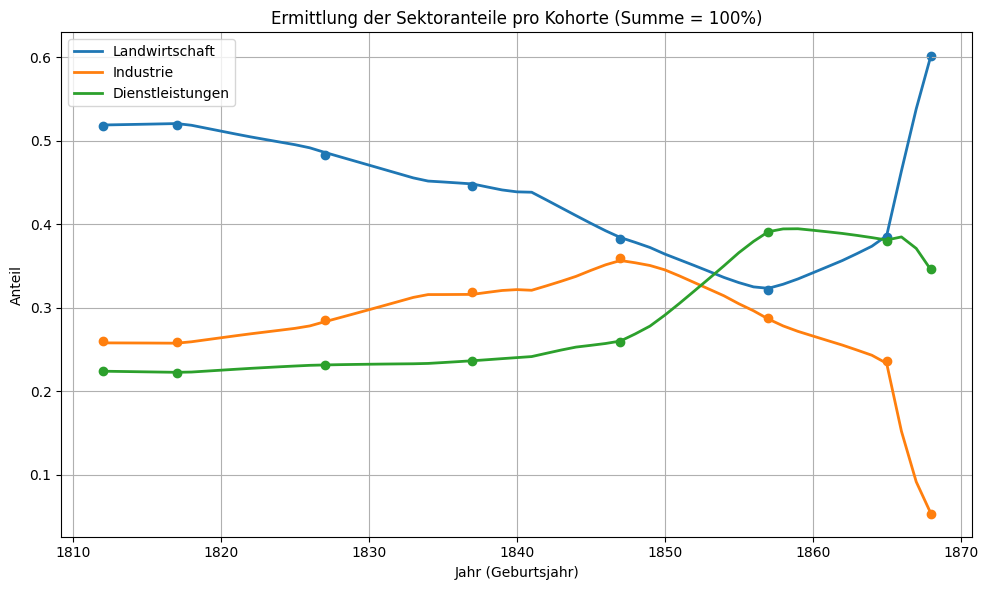


✅ csv file is saved.


In [4]:
# Relevant columns extraction
years = df_mv.iloc[:, 1].values.astype(np.float32)
sectors = df_mv.iloc[:, 3:6].values.astype(np.float32)

# Normalization
years_min = years.min()
years_max = years.max()
years_norm = (years - years_min) / (years_max - years_min)

# Model (sum = 1)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(1,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy")
model.fit(years_norm, sectors, epochs=1000, verbose=0)

# Imputation of the missing values
all_years = np.arange(int(years_min), int(years_max) + 1, dtype=np.float32)
all_years_norm = (all_years - years_min) / (years_max - years_min)
predicted_sectors = model.predict(all_years_norm)

# Results in the DataFrame
result_df = pd.DataFrame({
    "year_of_birth": all_years.astype(int),
    "year_of_census": year,
    "1. Sector": predicted_sectors[:, 0],
    "2. Sector": predicted_sectors[:, 1],
    "3. Sector": predicted_sectors[:, 2]
})

print(result_df.head())
print(result_df.dtypes)

# integrate the data from census
result_df.set_index('year_of_birth', inplace=True)
df_mv.set_index('year_of_birth', inplace=True)
result_df.update(df_mv)
result_df.reset_index(inplace=True)
result_df.iloc[:, -3:] = result_df.iloc[:, -3:].round(3)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(all_years, predicted_sectors[:, 0], label="Landwirtschaft", linewidth=2)
plt.plot(all_years, predicted_sectors[:, 1], label="Industrie", linewidth=2)
plt.plot(all_years, predicted_sectors[:, 2], label="Dienstleistungen", linewidth=2)
plt.scatter(years, sectors[:, 0], c='tab:blue', marker='o')
plt.scatter(years, sectors[:, 1], c='tab:orange', marker='o')
plt.scatter(years, sectors[:, 2], c='tab:green', marker='o')
plt.xlabel("Jahr (Geburtsjahr)")
plt.ylabel("Anteil")
plt.title("Ermittlung der Sektoranteile pro Kohorte (Summe = 100%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# save to csv file

name_export = "interpolierte_sektoren_sh_" + str(year) +".csv"

result_df.to_csv(name_export, index=False)
print("\n✅ csv file is saved.")
